# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import wandb

#### WandB

In [2]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-2,
    "architecture": "3 Hidden, 200 Neurons",
    "dataset": "eq_dataset.npz",
    "epochs": 200,
    }
)

wandb: Currently logged in as: sinaramsayer. Use `wandb login --relogin` to force relogin


#### Default Datentyp

In [3]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [4]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            #nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [5]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [6]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [7]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [8]:
# learning_rate = 1e-3
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [9]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [10]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    
    # log metrics to wandb
    wandb.log({"Train loss": tr_loss, "Test loss": t_loss, "Train MRE": tr_MRE, "Test MRE": t_MRE})

Epoch 1/200, Iteration 1/25, Loss: 0.0820
Epoch 1/200, Iteration 2/25, Loss: 1.2392
Epoch 1/200, Iteration 3/25, Loss: 3.6684
Epoch 1/200, Iteration 4/25, Loss: 2.3203
Epoch 1/200, Iteration 5/25, Loss: 1.1119
Epoch 1/200, Iteration 6/25, Loss: 0.2559
Epoch 1/200, Iteration 7/25, Loss: 0.8406
Epoch 1/200, Iteration 8/25, Loss: 0.6361
Epoch 1/200, Iteration 9/25, Loss: 0.5297
Epoch 1/200, Iteration 10/25, Loss: 0.2323
Epoch 1/200, Iteration 11/25, Loss: 0.2559
Epoch 1/200, Iteration 12/25, Loss: 0.3382
Epoch 1/200, Iteration 13/25, Loss: 0.3081
Epoch 1/200, Iteration 14/25, Loss: 0.3241
Epoch 1/200, Iteration 15/25, Loss: 0.3265
Epoch 1/200, Iteration 16/25, Loss: 0.1441
Epoch 1/200, Iteration 17/25, Loss: 0.3030
Epoch 1/200, Iteration 18/25, Loss: 0.1714
Epoch 1/200, Iteration 19/25, Loss: 0.2566
Epoch 1/200, Iteration 20/25, Loss: 0.2713
Epoch 1/200, Iteration 21/25, Loss: 0.1405
Epoch 1/200, Iteration 22/25, Loss: 0.2097
Epoch 1/200, Iteration 23/25, Loss: 0.1504
Epoch 1/200, Iterati


Epoch 8/200, Iteration 1/25, Loss: 0.0520
Epoch 8/200, Iteration 2/25, Loss: 0.0639
Epoch 8/200, Iteration 3/25, Loss: 0.0462
Epoch 8/200, Iteration 4/25, Loss: 0.0500
Epoch 8/200, Iteration 5/25, Loss: 0.0537
Epoch 8/200, Iteration 6/25, Loss: 0.0525
Epoch 8/200, Iteration 7/25, Loss: 0.0606
Epoch 8/200, Iteration 8/25, Loss: 0.0772
Epoch 8/200, Iteration 9/25, Loss: 0.0696
Epoch 8/200, Iteration 10/25, Loss: 0.0523
Epoch 8/200, Iteration 11/25, Loss: 0.0358
Epoch 8/200, Iteration 12/25, Loss: 0.0431
Epoch 8/200, Iteration 13/25, Loss: 0.0480
Epoch 8/200, Iteration 14/25, Loss: 0.0671
Epoch 8/200, Iteration 15/25, Loss: 0.0485
Epoch 8/200, Iteration 16/25, Loss: 0.0406
Epoch 8/200, Iteration 17/25, Loss: 0.0302
Epoch 8/200, Iteration 18/25, Loss: 0.0313
Epoch 8/200, Iteration 19/25, Loss: 0.0276
Epoch 8/200, Iteration 20/25, Loss: 0.0375
Epoch 8/200, Iteration 21/25, Loss: 0.0271
Epoch 8/200, Iteration 22/25, Loss: 0.0401
Epoch 8/200, Iteration 23/25, Loss: 0.0657
Epoch 8/200, Iterat

Epoch 14/200, Iteration 24/25, Loss: 0.0758
Epoch 14/200, Iteration 25/25, Loss: 0.0755
Train Error: 
 Accuracy: 45.25%, Avg loss: 0.050295, MRE: 2.252673 

Test Error: 
 Accuracy: 43.5%, Avg loss: 0.056735, MRE: 6.051951 

Epoch 15/200, Iteration 1/25, Loss: 0.0378
Epoch 15/200, Iteration 2/25, Loss: 0.0655
Epoch 15/200, Iteration 3/25, Loss: 0.0322
Epoch 15/200, Iteration 4/25, Loss: 0.0323
Epoch 15/200, Iteration 5/25, Loss: 0.0525
Epoch 15/200, Iteration 6/25, Loss: 0.0737
Epoch 15/200, Iteration 7/25, Loss: 0.0403
Epoch 15/200, Iteration 8/25, Loss: 0.0984
Epoch 15/200, Iteration 9/25, Loss: 0.0880
Epoch 15/200, Iteration 10/25, Loss: 0.0706
Epoch 15/200, Iteration 11/25, Loss: 0.0770
Epoch 15/200, Iteration 12/25, Loss: 0.0472
Epoch 15/200, Iteration 13/25, Loss: 0.0495
Epoch 15/200, Iteration 14/25, Loss: 0.0392
Epoch 15/200, Iteration 15/25, Loss: 0.0384
Epoch 15/200, Iteration 16/25, Loss: 0.0533
Epoch 15/200, Iteration 17/25, Loss: 0.0384
Epoch 15/200, Iteration 18/25, Loss: 

Epoch 21/200, Iteration 17/25, Loss: 0.1124
Epoch 21/200, Iteration 18/25, Loss: 0.1426
Epoch 21/200, Iteration 19/25, Loss: 0.0973
Epoch 21/200, Iteration 20/25, Loss: 0.0692
Epoch 21/200, Iteration 21/25, Loss: 0.0860
Epoch 21/200, Iteration 22/25, Loss: 0.0708
Epoch 21/200, Iteration 23/25, Loss: 0.1171
Epoch 21/200, Iteration 24/25, Loss: 0.0585
Epoch 21/200, Iteration 25/25, Loss: 0.1481
Train Error: 
 Accuracy: 5.5%, Avg loss: 0.128718, MRE: 6.004749 

Test Error: 
 Accuracy: 6.0%, Avg loss: 0.134129, MRE: 7.029272 

Epoch 22/200, Iteration 1/25, Loss: 0.1059
Epoch 22/200, Iteration 2/25, Loss: 0.0985
Epoch 22/200, Iteration 3/25, Loss: 0.1048
Epoch 22/200, Iteration 4/25, Loss: 0.0654
Epoch 22/200, Iteration 5/25, Loss: 0.0761
Epoch 22/200, Iteration 6/25, Loss: 0.0743
Epoch 22/200, Iteration 7/25, Loss: 0.0648
Epoch 22/200, Iteration 8/25, Loss: 0.0656
Epoch 22/200, Iteration 9/25, Loss: 0.0654
Epoch 22/200, Iteration 10/25, Loss: 0.0283
Epoch 22/200, Iteration 11/25, Loss: 0.0

Epoch 28/200, Iteration 17/25, Loss: 0.0164
Epoch 28/200, Iteration 18/25, Loss: 0.0126
Epoch 28/200, Iteration 19/25, Loss: 0.0112
Epoch 28/200, Iteration 20/25, Loss: 0.0149
Epoch 28/200, Iteration 21/25, Loss: 0.0271
Epoch 28/200, Iteration 22/25, Loss: 0.0204
Epoch 28/200, Iteration 23/25, Loss: 0.0383
Epoch 28/200, Iteration 24/25, Loss: 0.0260
Epoch 28/200, Iteration 25/25, Loss: 0.0256
Train Error: 
 Accuracy: 91.88%, Avg loss: 0.020136, MRE: 1.062906 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.021403, MRE: 3.540027 

Epoch 29/200, Iteration 1/25, Loss: 0.0425
Epoch 29/200, Iteration 2/25, Loss: 0.0223
Epoch 29/200, Iteration 3/25, Loss: 0.0202
Epoch 29/200, Iteration 4/25, Loss: 0.0171
Epoch 29/200, Iteration 5/25, Loss: 0.0227
Epoch 29/200, Iteration 6/25, Loss: 0.0362
Epoch 29/200, Iteration 7/25, Loss: 0.0262
Epoch 29/200, Iteration 8/25, Loss: 0.0158
Epoch 29/200, Iteration 9/25, Loss: 0.0163
Epoch 29/200, Iteration 10/25, Loss: 0.0190
Epoch 29/200, Iteration 11/25, Loss: 

Epoch 35/200, Iteration 22/25, Loss: 0.0114
Epoch 35/200, Iteration 23/25, Loss: 0.0260
Epoch 35/200, Iteration 24/25, Loss: 0.0246
Epoch 35/200, Iteration 25/25, Loss: 0.0440
Train Error: 
 Accuracy: 27.38%, Avg loss: 0.031834, MRE: 2.729164 

Test Error: 
 Accuracy: 30.5%, Avg loss: 0.029808, MRE: 3.696086 

Epoch 36/200, Iteration 1/25, Loss: 0.0420
Epoch 36/200, Iteration 2/25, Loss: 0.0261
Epoch 36/200, Iteration 3/25, Loss: 0.0143
Epoch 36/200, Iteration 4/25, Loss: 0.0118
Epoch 36/200, Iteration 5/25, Loss: 0.0566
Epoch 36/200, Iteration 6/25, Loss: 0.0318
Epoch 36/200, Iteration 7/25, Loss: 0.0203
Epoch 36/200, Iteration 8/25, Loss: 0.0257
Epoch 36/200, Iteration 9/25, Loss: 0.0274
Epoch 36/200, Iteration 10/25, Loss: 0.0124
Epoch 36/200, Iteration 11/25, Loss: 0.0653
Epoch 36/200, Iteration 12/25, Loss: 0.0305
Epoch 36/200, Iteration 13/25, Loss: 0.0395
Epoch 36/200, Iteration 14/25, Loss: 0.0404
Epoch 36/200, Iteration 15/25, Loss: 0.0367
Epoch 36/200, Iteration 16/25, Loss: 

Epoch 42/200, Iteration 21/25, Loss: 0.0292
Epoch 42/200, Iteration 22/25, Loss: 0.0213
Epoch 42/200, Iteration 23/25, Loss: 0.0281
Epoch 42/200, Iteration 24/25, Loss: 0.0112
Epoch 42/200, Iteration 25/25, Loss: 0.0218
Train Error: 
 Accuracy: 79.62%, Avg loss: 0.010474, MRE: 0.652436 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.011066, MRE: 2.346212 

Epoch 43/200, Iteration 1/25, Loss: 0.0222
Epoch 43/200, Iteration 2/25, Loss: 0.0152
Epoch 43/200, Iteration 3/25, Loss: 0.0139
Epoch 43/200, Iteration 4/25, Loss: 0.0110
Epoch 43/200, Iteration 5/25, Loss: 0.0323
Epoch 43/200, Iteration 6/25, Loss: 0.0188
Epoch 43/200, Iteration 7/25, Loss: 0.0214
Epoch 43/200, Iteration 8/25, Loss: 0.0314
Epoch 43/200, Iteration 9/25, Loss: 0.0138
Epoch 43/200, Iteration 10/25, Loss: 0.0133
Epoch 43/200, Iteration 11/25, Loss: 0.0112
Epoch 43/200, Iteration 12/25, Loss: 0.0125
Epoch 43/200, Iteration 13/25, Loss: 0.0401
Epoch 43/200, Iteration 14/25, Loss: 0.0131
Epoch 43/200, Iteration 15/25, Loss: 

Epoch 49/200, Iteration 18/25, Loss: 0.0112
Epoch 49/200, Iteration 19/25, Loss: 0.0126
Epoch 49/200, Iteration 20/25, Loss: 0.0100
Epoch 49/200, Iteration 21/25, Loss: 0.0376
Epoch 49/200, Iteration 22/25, Loss: 0.0195
Epoch 49/200, Iteration 23/25, Loss: 0.0100
Epoch 49/200, Iteration 24/25, Loss: 0.0186
Epoch 49/200, Iteration 25/25, Loss: 0.0159
Train Error: 
 Accuracy: 74.0%, Avg loss: 0.009085, MRE: 0.687500 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.010063, MRE: 1.785375 

Epoch 50/200, Iteration 1/25, Loss: 0.0108
Epoch 50/200, Iteration 2/25, Loss: 0.0208
Epoch 50/200, Iteration 3/25, Loss: 0.0160
Epoch 50/200, Iteration 4/25, Loss: 0.0110
Epoch 50/200, Iteration 5/25, Loss: 0.0133
Epoch 50/200, Iteration 6/25, Loss: 0.0177
Epoch 50/200, Iteration 7/25, Loss: 0.0110
Epoch 50/200, Iteration 8/25, Loss: 0.0086
Epoch 50/200, Iteration 9/25, Loss: 0.0097
Epoch 50/200, Iteration 10/25, Loss: 0.0278
Epoch 50/200, Iteration 11/25, Loss: 0.0378
Epoch 50/200, Iteration 12/25, Loss: 0

Epoch 56/200, Iteration 23/25, Loss: 0.0273
Epoch 56/200, Iteration 24/25, Loss: 0.0189
Epoch 56/200, Iteration 25/25, Loss: 0.0140
Train Error: 
 Accuracy: 74.5%, Avg loss: 0.011411, MRE: 0.676182 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.012447, MRE: 2.235765 

Epoch 57/200, Iteration 1/25, Loss: 0.0244
Epoch 57/200, Iteration 2/25, Loss: 0.0176
Epoch 57/200, Iteration 3/25, Loss: 0.0404
Epoch 57/200, Iteration 4/25, Loss: 0.0162
Epoch 57/200, Iteration 5/25, Loss: 0.0292
Epoch 57/200, Iteration 6/25, Loss: 0.0085
Epoch 57/200, Iteration 7/25, Loss: 0.0143
Epoch 57/200, Iteration 8/25, Loss: 0.0227
Epoch 57/200, Iteration 9/25, Loss: 0.0176
Epoch 57/200, Iteration 10/25, Loss: 0.0212
Epoch 57/200, Iteration 11/25, Loss: 0.0120
Epoch 57/200, Iteration 12/25, Loss: 0.0133
Epoch 57/200, Iteration 13/25, Loss: 0.0155
Epoch 57/200, Iteration 14/25, Loss: 0.0084
Epoch 57/200, Iteration 15/25, Loss: 0.0116
Epoch 57/200, Iteration 16/25, Loss: 0.0156
Epoch 57/200, Iteration 17/25, Loss: 0

Epoch 63/200, Iteration 18/25, Loss: 0.0177
Epoch 63/200, Iteration 19/25, Loss: 0.0160
Epoch 63/200, Iteration 20/25, Loss: 0.0215
Epoch 63/200, Iteration 21/25, Loss: 0.0139
Epoch 63/200, Iteration 22/25, Loss: 0.0140
Epoch 63/200, Iteration 23/25, Loss: 0.0160
Epoch 63/200, Iteration 24/25, Loss: 0.0148
Epoch 63/200, Iteration 25/25, Loss: 0.0162
Train Error: 
 Accuracy: 93.12%, Avg loss: 0.008180, MRE: 0.666340 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.008955, MRE: 2.268918 

Epoch 64/200, Iteration 1/25, Loss: 0.0146
Epoch 64/200, Iteration 2/25, Loss: 0.0226
Epoch 64/200, Iteration 3/25, Loss: 0.0165
Epoch 64/200, Iteration 4/25, Loss: 0.0184
Epoch 64/200, Iteration 5/25, Loss: 0.0092
Epoch 64/200, Iteration 6/25, Loss: 0.0262
Epoch 64/200, Iteration 7/25, Loss: 0.0267
Epoch 64/200, Iteration 8/25, Loss: 0.0190
Epoch 64/200, Iteration 9/25, Loss: 0.0214
Epoch 64/200, Iteration 10/25, Loss: 0.0115
Epoch 64/200, Iteration 11/25, Loss: 0.0242
Epoch 64/200, Iteration 12/25, Loss: 

Train Error: 
 Accuracy: 96.88%, Avg loss: 0.008911, MRE: 0.608836 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.009658, MRE: 2.342836 

Epoch 71/200, Iteration 1/25, Loss: 0.0135
Epoch 71/200, Iteration 2/25, Loss: 0.0217
Epoch 71/200, Iteration 3/25, Loss: 0.0208
Epoch 71/200, Iteration 4/25, Loss: 0.0138
Epoch 71/200, Iteration 5/25, Loss: 0.0359
Epoch 71/200, Iteration 6/25, Loss: 0.0255
Epoch 71/200, Iteration 7/25, Loss: 0.0107
Epoch 71/200, Iteration 8/25, Loss: 0.0087
Epoch 71/200, Iteration 9/25, Loss: 0.0106
Epoch 71/200, Iteration 10/25, Loss: 0.0114
Epoch 71/200, Iteration 11/25, Loss: 0.0381
Epoch 71/200, Iteration 12/25, Loss: 0.0226
Epoch 71/200, Iteration 13/25, Loss: 0.0312
Epoch 71/200, Iteration 14/25, Loss: 0.0235
Epoch 71/200, Iteration 15/25, Loss: 0.0147
Epoch 71/200, Iteration 16/25, Loss: 0.0146
Epoch 71/200, Iteration 17/25, Loss: 0.0132
Epoch 71/200, Iteration 18/25, Loss: 0.0105
Epoch 71/200, Iteration 19/25, Loss: 0.0179
Epoch 71/200, Iteration 20/25, Loss: 

Epoch 77/200, Iteration 18/25, Loss: 0.0162
Epoch 77/200, Iteration 19/25, Loss: 0.0148
Epoch 77/200, Iteration 20/25, Loss: 0.0206
Epoch 77/200, Iteration 21/25, Loss: 0.0311
Epoch 77/200, Iteration 22/25, Loss: 0.0181
Epoch 77/200, Iteration 23/25, Loss: 0.0201
Epoch 77/200, Iteration 24/25, Loss: 0.0298
Epoch 77/200, Iteration 25/25, Loss: 0.0100
Train Error: 
 Accuracy: 94.38%, Avg loss: 0.009093, MRE: 0.584098 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.009910, MRE: 2.288690 

Epoch 78/200, Iteration 1/25, Loss: 0.0166
Epoch 78/200, Iteration 2/25, Loss: 0.0112
Epoch 78/200, Iteration 3/25, Loss: 0.0313
Epoch 78/200, Iteration 4/25, Loss: 0.0208
Epoch 78/200, Iteration 5/25, Loss: 0.0118
Epoch 78/200, Iteration 6/25, Loss: 0.0192
Epoch 78/200, Iteration 7/25, Loss: 0.0180
Epoch 78/200, Iteration 8/25, Loss: 0.0259
Epoch 78/200, Iteration 9/25, Loss: 0.0484
Epoch 78/200, Iteration 10/25, Loss: 0.0242
Epoch 78/200, Iteration 11/25, Loss: 0.0103
Epoch 78/200, Iteration 12/25, Loss: 

Epoch 84/200, Iteration 25/25, Loss: 0.0128
Train Error: 
 Accuracy: 86.0%, Avg loss: 0.008864, MRE: 0.547764 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.009652, MRE: 2.632441 

Epoch 85/200, Iteration 1/25, Loss: 0.0092
Epoch 85/200, Iteration 2/25, Loss: 0.0096
Epoch 85/200, Iteration 3/25, Loss: 0.0134
Epoch 85/200, Iteration 4/25, Loss: 0.0204
Epoch 85/200, Iteration 5/25, Loss: 0.0255
Epoch 85/200, Iteration 6/25, Loss: 0.0125
Epoch 85/200, Iteration 7/25, Loss: 0.0096
Epoch 85/200, Iteration 8/25, Loss: 0.0181
Epoch 85/200, Iteration 9/25, Loss: 0.0122
Epoch 85/200, Iteration 10/25, Loss: 0.0221
Epoch 85/200, Iteration 11/25, Loss: 0.0251
Epoch 85/200, Iteration 12/25, Loss: 0.0406
Epoch 85/200, Iteration 13/25, Loss: 0.0073
Epoch 85/200, Iteration 14/25, Loss: 0.0166
Epoch 85/200, Iteration 15/25, Loss: 0.0231
Epoch 85/200, Iteration 16/25, Loss: 0.0314
Epoch 85/200, Iteration 17/25, Loss: 0.0207
Epoch 85/200, Iteration 18/25, Loss: 0.0102
Epoch 85/200, Iteration 19/25, Loss: 0

Epoch 91/200, Iteration 17/25, Loss: 0.0170
Epoch 91/200, Iteration 18/25, Loss: 0.0160
Epoch 91/200, Iteration 19/25, Loss: 0.0254
Epoch 91/200, Iteration 20/25, Loss: 0.0116
Epoch 91/200, Iteration 21/25, Loss: 0.0156
Epoch 91/200, Iteration 22/25, Loss: 0.0082
Epoch 91/200, Iteration 23/25, Loss: 0.0097
Epoch 91/200, Iteration 24/25, Loss: 0.0347
Epoch 91/200, Iteration 25/25, Loss: 0.0076
Train Error: 
 Accuracy: 93.0%, Avg loss: 0.007453, MRE: 0.542167 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.008239, MRE: 2.083382 

Epoch 92/200, Iteration 1/25, Loss: 0.0136
Epoch 92/200, Iteration 2/25, Loss: 0.0095
Epoch 92/200, Iteration 3/25, Loss: 0.0066
Epoch 92/200, Iteration 4/25, Loss: 0.0085
Epoch 92/200, Iteration 5/25, Loss: 0.0125
Epoch 92/200, Iteration 6/25, Loss: 0.0240
Epoch 92/200, Iteration 7/25, Loss: 0.0241
Epoch 92/200, Iteration 8/25, Loss: 0.0433
Epoch 92/200, Iteration 9/25, Loss: 0.0135
Epoch 92/200, Iteration 10/25, Loss: 0.0230
Epoch 92/200, Iteration 11/25, Loss: 0

Epoch 98/200, Iteration 24/25, Loss: 0.0137
Epoch 98/200, Iteration 25/25, Loss: 0.0114
Train Error: 
 Accuracy: 70.88%, Avg loss: 0.008970, MRE: 0.500130 

Test Error: 
 Accuracy: 66.0%, Avg loss: 0.010263, MRE: 1.711280 

Epoch 99/200, Iteration 1/25, Loss: 0.0225
Epoch 99/200, Iteration 2/25, Loss: 0.0098
Epoch 99/200, Iteration 3/25, Loss: 0.0148
Epoch 99/200, Iteration 4/25, Loss: 0.0091
Epoch 99/200, Iteration 5/25, Loss: 0.0097
Epoch 99/200, Iteration 6/25, Loss: 0.0165
Epoch 99/200, Iteration 7/25, Loss: 0.0136
Epoch 99/200, Iteration 8/25, Loss: 0.0292
Epoch 99/200, Iteration 9/25, Loss: 0.0254
Epoch 99/200, Iteration 10/25, Loss: 0.0075
Epoch 99/200, Iteration 11/25, Loss: 0.0137
Epoch 99/200, Iteration 12/25, Loss: 0.0104
Epoch 99/200, Iteration 13/25, Loss: 0.0139
Epoch 99/200, Iteration 14/25, Loss: 0.0085
Epoch 99/200, Iteration 15/25, Loss: 0.0174
Epoch 99/200, Iteration 16/25, Loss: 0.0279
Epoch 99/200, Iteration 17/25, Loss: 0.0127
Epoch 99/200, Iteration 18/25, Loss: 

Epoch 105/200, Iteration 21/25, Loss: 0.0125
Epoch 105/200, Iteration 22/25, Loss: 0.0113
Epoch 105/200, Iteration 23/25, Loss: 0.0123
Epoch 105/200, Iteration 24/25, Loss: 0.0069
Epoch 105/200, Iteration 25/25, Loss: 0.0159
Train Error: 
 Accuracy: 87.0%, Avg loss: 0.006572, MRE: 0.556651 

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.007286, MRE: 1.965843 

Epoch 106/200, Iteration 1/25, Loss: 0.0074
Epoch 106/200, Iteration 2/25, Loss: 0.0081
Epoch 106/200, Iteration 3/25, Loss: 0.0093
Epoch 106/200, Iteration 4/25, Loss: 0.0185
Epoch 106/200, Iteration 5/25, Loss: 0.0081
Epoch 106/200, Iteration 6/25, Loss: 0.0323
Epoch 106/200, Iteration 7/25, Loss: 0.0092
Epoch 106/200, Iteration 8/25, Loss: 0.0089
Epoch 106/200, Iteration 9/25, Loss: 0.0088
Epoch 106/200, Iteration 10/25, Loss: 0.0094
Epoch 106/200, Iteration 11/25, Loss: 0.0229
Epoch 106/200, Iteration 12/25, Loss: 0.0076
Epoch 106/200, Iteration 13/25, Loss: 0.0091
Epoch 106/200, Iteration 14/25, Loss: 0.0166
Epoch 106/200, Iter

Epoch 112/200, Iteration 18/25, Loss: 0.0115
Epoch 112/200, Iteration 19/25, Loss: 0.0116
Epoch 112/200, Iteration 20/25, Loss: 0.0378
Epoch 112/200, Iteration 21/25, Loss: 0.0111
Epoch 112/200, Iteration 22/25, Loss: 0.0171
Epoch 112/200, Iteration 23/25, Loss: 0.0119
Epoch 112/200, Iteration 24/25, Loss: 0.0153
Epoch 112/200, Iteration 25/25, Loss: 0.0087
Train Error: 
 Accuracy: 91.25%, Avg loss: 0.006385, MRE: 0.498143 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.007129, MRE: 2.037567 

Epoch 113/200, Iteration 1/25, Loss: 0.0062
Epoch 113/200, Iteration 2/25, Loss: 0.0201
Epoch 113/200, Iteration 3/25, Loss: 0.0113
Epoch 113/200, Iteration 4/25, Loss: 0.0078
Epoch 113/200, Iteration 5/25, Loss: 0.0073
Epoch 113/200, Iteration 6/25, Loss: 0.0240
Epoch 113/200, Iteration 7/25, Loss: 0.0117
Epoch 113/200, Iteration 8/25, Loss: 0.0104
Epoch 113/200, Iteration 9/25, Loss: 0.0367
Epoch 113/200, Iteration 10/25, Loss: 0.0120
Epoch 113/200, Iteration 11/25, Loss: 0.0088
Epoch 113/200, Ite

Epoch 119/200, Iteration 15/25, Loss: 0.0144
Epoch 119/200, Iteration 16/25, Loss: 0.0083
Epoch 119/200, Iteration 17/25, Loss: 0.0060
Epoch 119/200, Iteration 18/25, Loss: 0.0120
Epoch 119/200, Iteration 19/25, Loss: 0.0126
Epoch 119/200, Iteration 20/25, Loss: 0.0088
Epoch 119/200, Iteration 21/25, Loss: 0.0175
Epoch 119/200, Iteration 22/25, Loss: 0.0131
Epoch 119/200, Iteration 23/25, Loss: 0.0127
Epoch 119/200, Iteration 24/25, Loss: 0.0175
Epoch 119/200, Iteration 25/25, Loss: 0.0266
Train Error: 
 Accuracy: 81.38%, Avg loss: 0.006921, MRE: 0.566188 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.007663, MRE: 1.868088 

Epoch 120/200, Iteration 1/25, Loss: 0.0087
Epoch 120/200, Iteration 2/25, Loss: 0.0190
Epoch 120/200, Iteration 3/25, Loss: 0.0085
Epoch 120/200, Iteration 4/25, Loss: 0.0140
Epoch 120/200, Iteration 5/25, Loss: 0.0180
Epoch 120/200, Iteration 6/25, Loss: 0.0098
Epoch 120/200, Iteration 7/25, Loss: 0.0176
Epoch 120/200, Iteration 8/25, Loss: 0.0138
Epoch 120/200, It

Epoch 126/200, Iteration 18/25, Loss: 0.0118
Epoch 126/200, Iteration 19/25, Loss: 0.0110
Epoch 126/200, Iteration 20/25, Loss: 0.0207
Epoch 126/200, Iteration 21/25, Loss: 0.0168
Epoch 126/200, Iteration 22/25, Loss: 0.0090
Epoch 126/200, Iteration 23/25, Loss: 0.0106
Epoch 126/200, Iteration 24/25, Loss: 0.0097
Epoch 126/200, Iteration 25/25, Loss: 0.0073
Train Error: 
 Accuracy: 86.88%, Avg loss: 0.006615, MRE: 0.570457 

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.007097, MRE: 1.785993 

Epoch 127/200, Iteration 1/25, Loss: 0.0077
Epoch 127/200, Iteration 2/25, Loss: 0.0101
Epoch 127/200, Iteration 3/25, Loss: 0.0074
Epoch 127/200, Iteration 4/25, Loss: 0.0108
Epoch 127/200, Iteration 5/25, Loss: 0.0096
Epoch 127/200, Iteration 6/25, Loss: 0.0078
Epoch 127/200, Iteration 7/25, Loss: 0.0095
Epoch 127/200, Iteration 8/25, Loss: 0.0094
Epoch 127/200, Iteration 9/25, Loss: 0.0141
Epoch 127/200, Iteration 10/25, Loss: 0.0109
Epoch 127/200, Iteration 11/25, Loss: 0.0081
Epoch 127/200, Ite

Epoch 133/200, Iteration 17/25, Loss: 0.0177
Epoch 133/200, Iteration 18/25, Loss: 0.0143
Epoch 133/200, Iteration 19/25, Loss: 0.0239
Epoch 133/200, Iteration 20/25, Loss: 0.0104
Epoch 133/200, Iteration 21/25, Loss: 0.0195
Epoch 133/200, Iteration 22/25, Loss: 0.0249
Epoch 133/200, Iteration 23/25, Loss: 0.0124
Epoch 133/200, Iteration 24/25, Loss: 0.0162
Epoch 133/200, Iteration 25/25, Loss: 0.0152
Train Error: 
 Accuracy: 89.62%, Avg loss: 0.006395, MRE: 0.477606 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.007153, MRE: 1.806494 

Epoch 134/200, Iteration 1/25, Loss: 0.0100
Epoch 134/200, Iteration 2/25, Loss: 0.0070
Epoch 134/200, Iteration 3/25, Loss: 0.0308
Epoch 134/200, Iteration 4/25, Loss: 0.0124
Epoch 134/200, Iteration 5/25, Loss: 0.0079
Epoch 134/200, Iteration 6/25, Loss: 0.0198
Epoch 134/200, Iteration 7/25, Loss: 0.0280
Epoch 134/200, Iteration 8/25, Loss: 0.0446
Epoch 134/200, Iteration 9/25, Loss: 0.0184
Epoch 134/200, Iteration 10/25, Loss: 0.0139
Epoch 134/200, Ite

Epoch 140/200, Iteration 7/25, Loss: 0.0151
Epoch 140/200, Iteration 8/25, Loss: 0.0194
Epoch 140/200, Iteration 9/25, Loss: 0.0097
Epoch 140/200, Iteration 10/25, Loss: 0.0134
Epoch 140/200, Iteration 11/25, Loss: 0.0090
Epoch 140/200, Iteration 12/25, Loss: 0.0106
Epoch 140/200, Iteration 13/25, Loss: 0.0218
Epoch 140/200, Iteration 14/25, Loss: 0.0078
Epoch 140/200, Iteration 15/25, Loss: 0.0145
Epoch 140/200, Iteration 16/25, Loss: 0.0077
Epoch 140/200, Iteration 17/25, Loss: 0.0080
Epoch 140/200, Iteration 18/25, Loss: 0.0202
Epoch 140/200, Iteration 19/25, Loss: 0.0084
Epoch 140/200, Iteration 20/25, Loss: 0.0074
Epoch 140/200, Iteration 21/25, Loss: 0.0092
Epoch 140/200, Iteration 22/25, Loss: 0.0067
Epoch 140/200, Iteration 23/25, Loss: 0.0224
Epoch 140/200, Iteration 24/25, Loss: 0.0159
Epoch 140/200, Iteration 25/25, Loss: 0.0086
Train Error: 
 Accuracy: 93.75%, Avg loss: 0.006194, MRE: 0.472984 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.006718, MRE: 1.886684 

Epoch 141/20

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.007126, MRE: 1.842087 

Epoch 147/200, Iteration 1/25, Loss: 0.0164
Epoch 147/200, Iteration 2/25, Loss: 0.0058
Epoch 147/200, Iteration 3/25, Loss: 0.0135
Epoch 147/200, Iteration 4/25, Loss: 0.0098
Epoch 147/200, Iteration 5/25, Loss: 0.0179
Epoch 147/200, Iteration 6/25, Loss: 0.0085
Epoch 147/200, Iteration 7/25, Loss: 0.0269
Epoch 147/200, Iteration 8/25, Loss: 0.0171
Epoch 147/200, Iteration 9/25, Loss: 0.0328
Epoch 147/200, Iteration 10/25, Loss: 0.0234
Epoch 147/200, Iteration 11/25, Loss: 0.0067
Epoch 147/200, Iteration 12/25, Loss: 0.0087
Epoch 147/200, Iteration 13/25, Loss: 0.0096
Epoch 147/200, Iteration 14/25, Loss: 0.0072
Epoch 147/200, Iteration 15/25, Loss: 0.0074
Epoch 147/200, Iteration 16/25, Loss: 0.0113
Epoch 147/200, Iteration 17/25, Loss: 0.0086
Epoch 147/200, Iteration 18/25, Loss: 0.0135
Epoch 147/200, Iteration 19/25, Loss: 0.0206
Epoch 147/200, Iteration 20/25, Loss: 0.0076
Epoch 147/200, Iteration 21/25, Loss: 0.00

Epoch 153/200, Iteration 24/25, Loss: 0.0177
Epoch 153/200, Iteration 25/25, Loss: 0.0086
Train Error: 
 Accuracy: 83.12%, Avg loss: 0.006784, MRE: 0.521412 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.007720, MRE: 1.797229 

Epoch 154/200, Iteration 1/25, Loss: 0.0160
Epoch 154/200, Iteration 2/25, Loss: 0.0297
Epoch 154/200, Iteration 3/25, Loss: 0.0249
Epoch 154/200, Iteration 4/25, Loss: 0.0080
Epoch 154/200, Iteration 5/25, Loss: 0.0068
Epoch 154/200, Iteration 6/25, Loss: 0.0110
Epoch 154/200, Iteration 7/25, Loss: 0.0299
Epoch 154/200, Iteration 8/25, Loss: 0.0154
Epoch 154/200, Iteration 9/25, Loss: 0.0085
Epoch 154/200, Iteration 10/25, Loss: 0.0284
Epoch 154/200, Iteration 11/25, Loss: 0.0110
Epoch 154/200, Iteration 12/25, Loss: 0.0330
Epoch 154/200, Iteration 13/25, Loss: 0.0302
Epoch 154/200, Iteration 14/25, Loss: 0.0425
Epoch 154/200, Iteration 15/25, Loss: 0.0143
Epoch 154/200, Iteration 16/25, Loss: 0.0128
Epoch 154/200, Iteration 17/25, Loss: 0.0159
Epoch 154/200, Ite

Epoch 160/200, Iteration 14/25, Loss: 0.0088
Epoch 160/200, Iteration 15/25, Loss: 0.0320
Epoch 160/200, Iteration 16/25, Loss: 0.0218
Epoch 160/200, Iteration 17/25, Loss: 0.0079
Epoch 160/200, Iteration 18/25, Loss: 0.0290
Epoch 160/200, Iteration 19/25, Loss: 0.0173
Epoch 160/200, Iteration 20/25, Loss: 0.0075
Epoch 160/200, Iteration 21/25, Loss: 0.0116
Epoch 160/200, Iteration 22/25, Loss: 0.0176
Epoch 160/200, Iteration 23/25, Loss: 0.0101
Epoch 160/200, Iteration 24/25, Loss: 0.0101
Epoch 160/200, Iteration 25/25, Loss: 0.0219
Train Error: 
 Accuracy: 84.75%, Avg loss: 0.006700, MRE: 0.497248 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.007654, MRE: 1.842452 

Epoch 161/200, Iteration 1/25, Loss: 0.0110
Epoch 161/200, Iteration 2/25, Loss: 0.0112
Epoch 161/200, Iteration 3/25, Loss: 0.0126
Epoch 161/200, Iteration 4/25, Loss: 0.0208
Epoch 161/200, Iteration 5/25, Loss: 0.0118
Epoch 161/200, Iteration 6/25, Loss: 0.0128
Epoch 161/200, Iteration 7/25, Loss: 0.0097
Epoch 161/200, I

Epoch 167/200, Iteration 17/25, Loss: 0.0106
Epoch 167/200, Iteration 18/25, Loss: 0.0074
Epoch 167/200, Iteration 19/25, Loss: 0.0067
Epoch 167/200, Iteration 20/25, Loss: 0.0060
Epoch 167/200, Iteration 21/25, Loss: 0.0081
Epoch 167/200, Iteration 22/25, Loss: 0.0159
Epoch 167/200, Iteration 23/25, Loss: 0.0102
Epoch 167/200, Iteration 24/25, Loss: 0.0263
Epoch 167/200, Iteration 25/25, Loss: 0.0168
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.006319, MRE: 0.473559 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.007073, MRE: 1.994559 

Epoch 168/200, Iteration 1/25, Loss: 0.0081
Epoch 168/200, Iteration 2/25, Loss: 0.0155
Epoch 168/200, Iteration 3/25, Loss: 0.0129
Epoch 168/200, Iteration 4/25, Loss: 0.0084
Epoch 168/200, Iteration 5/25, Loss: 0.0280
Epoch 168/200, Iteration 6/25, Loss: 0.0166
Epoch 168/200, Iteration 7/25, Loss: 0.0190
Epoch 168/200, Iteration 8/25, Loss: 0.0105
Epoch 168/200, Iteration 9/25, Loss: 0.0122
Epoch 168/200, Iteration 10/25, Loss: 0.0069
Epoch 168/200, Ite

Epoch 174/200, Iteration 20/25, Loss: 0.0165
Epoch 174/200, Iteration 21/25, Loss: 0.0175
Epoch 174/200, Iteration 22/25, Loss: 0.0129
Epoch 174/200, Iteration 23/25, Loss: 0.0109
Epoch 174/200, Iteration 24/25, Loss: 0.0168
Epoch 174/200, Iteration 25/25, Loss: 0.0121
Train Error: 
 Accuracy: 92.12%, Avg loss: 0.006164, MRE: 0.500506 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.006719, MRE: 1.909761 

Epoch 175/200, Iteration 1/25, Loss: 0.0092
Epoch 175/200, Iteration 2/25, Loss: 0.0280
Epoch 175/200, Iteration 3/25, Loss: 0.0107
Epoch 175/200, Iteration 4/25, Loss: 0.0150
Epoch 175/200, Iteration 5/25, Loss: 0.0149
Epoch 175/200, Iteration 6/25, Loss: 0.0104
Epoch 175/200, Iteration 7/25, Loss: 0.0127
Epoch 175/200, Iteration 8/25, Loss: 0.0117
Epoch 175/200, Iteration 9/25, Loss: 0.0181
Epoch 175/200, Iteration 10/25, Loss: 0.0209
Epoch 175/200, Iteration 11/25, Loss: 0.0224
Epoch 175/200, Iteration 12/25, Loss: 0.0114
Epoch 175/200, Iteration 13/25, Loss: 0.0159
Epoch 175/200, Ite

Epoch 181/200, Iteration 20/25, Loss: 0.0126
Epoch 181/200, Iteration 21/25, Loss: 0.0101
Epoch 181/200, Iteration 22/25, Loss: 0.0231
Epoch 181/200, Iteration 23/25, Loss: 0.0083
Epoch 181/200, Iteration 24/25, Loss: 0.0067
Epoch 181/200, Iteration 25/25, Loss: 0.0101
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.006334, MRE: 0.490634 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.006937, MRE: 1.943965 

Epoch 182/200, Iteration 1/25, Loss: 0.0167
Epoch 182/200, Iteration 2/25, Loss: 0.0108
Epoch 182/200, Iteration 3/25, Loss: 0.0085
Epoch 182/200, Iteration 4/25, Loss: 0.0272
Epoch 182/200, Iteration 5/25, Loss: 0.0095
Epoch 182/200, Iteration 6/25, Loss: 0.0130
Epoch 182/200, Iteration 7/25, Loss: 0.0074
Epoch 182/200, Iteration 8/25, Loss: 0.0086
Epoch 182/200, Iteration 9/25, Loss: 0.0202
Epoch 182/200, Iteration 10/25, Loss: 0.0349
Epoch 182/200, Iteration 11/25, Loss: 0.0200
Epoch 182/200, Iteration 12/25, Loss: 0.0140
Epoch 182/200, Iteration 13/25, Loss: 0.0102
Epoch 182/200, Ite

Epoch 188/200, Iteration 22/25, Loss: 0.0191
Epoch 188/200, Iteration 23/25, Loss: 0.0082
Epoch 188/200, Iteration 24/25, Loss: 0.0087
Epoch 188/200, Iteration 25/25, Loss: 0.0054
Train Error: 
 Accuracy: 88.0%, Avg loss: 0.006418, MRE: 0.526996 

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.007037, MRE: 1.862784 

Epoch 189/200, Iteration 1/25, Loss: 0.0083
Epoch 189/200, Iteration 2/25, Loss: 0.0212
Epoch 189/200, Iteration 3/25, Loss: 0.0097
Epoch 189/200, Iteration 4/25, Loss: 0.0104
Epoch 189/200, Iteration 5/25, Loss: 0.0079
Epoch 189/200, Iteration 6/25, Loss: 0.0194
Epoch 189/200, Iteration 7/25, Loss: 0.0222
Epoch 189/200, Iteration 8/25, Loss: 0.0076
Epoch 189/200, Iteration 9/25, Loss: 0.0335
Epoch 189/200, Iteration 10/25, Loss: 0.0194
Epoch 189/200, Iteration 11/25, Loss: 0.0115
Epoch 189/200, Iteration 12/25, Loss: 0.0141
Epoch 189/200, Iteration 13/25, Loss: 0.0100
Epoch 189/200, Iteration 14/25, Loss: 0.0325
Epoch 189/200, Iteration 15/25, Loss: 0.0462
Epoch 189/200, Iter

Epoch 195/200, Iteration 14/25, Loss: 0.0206
Epoch 195/200, Iteration 15/25, Loss: 0.0110
Epoch 195/200, Iteration 16/25, Loss: 0.0189
Epoch 195/200, Iteration 17/25, Loss: 0.0257
Epoch 195/200, Iteration 18/25, Loss: 0.0103
Epoch 195/200, Iteration 19/25, Loss: 0.0330
Epoch 195/200, Iteration 20/25, Loss: 0.0103
Epoch 195/200, Iteration 21/25, Loss: 0.0121
Epoch 195/200, Iteration 22/25, Loss: 0.0105
Epoch 195/200, Iteration 23/25, Loss: 0.0100
Epoch 195/200, Iteration 24/25, Loss: 0.0246
Epoch 195/200, Iteration 25/25, Loss: 0.0081
Train Error: 
 Accuracy: 96.75%, Avg loss: 0.006366, MRE: 0.480703 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.007198, MRE: 1.968590 

Epoch 196/200, Iteration 1/25, Loss: 0.0162
Epoch 196/200, Iteration 2/25, Loss: 0.0104
Epoch 196/200, Iteration 3/25, Loss: 0.0081
Epoch 196/200, Iteration 4/25, Loss: 0.0102
Epoch 196/200, Iteration 5/25, Loss: 0.0087
Epoch 196/200, Iteration 6/25, Loss: 0.0085
Epoch 196/200, Iteration 7/25, Loss: 0.0114
Epoch 196/200, I

#### Plots loss vs Epoch

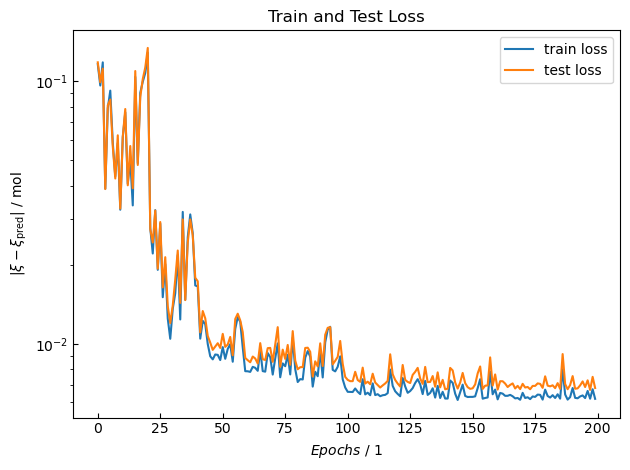

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9647851217180939
Test Dataset: R^2 = 0.9631019045535656
Max Error Training: |xi - xi_pred| = 0.06406409784157095
Max Error Test: |xi - xi_pred| = 0.06948460804262342


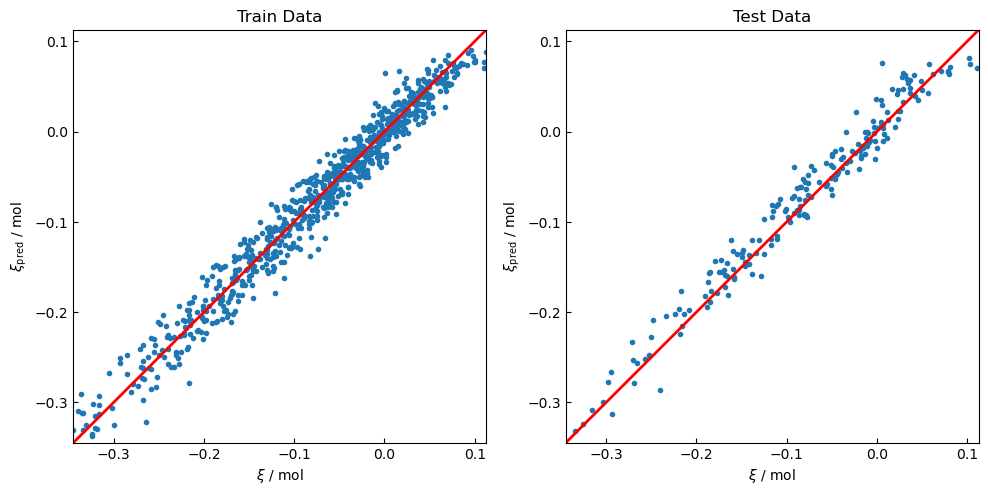

In [12]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))
print('Max Error Training: |xi - xi_pred| =', max_error(xi_real, xi_pred))
print('Max Error Test: |xi - xi_pred| =', max_error(xi_real_test, xi_pred_test))

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

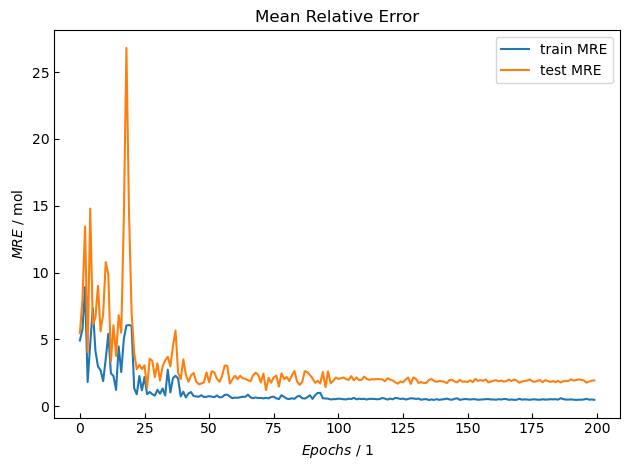

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

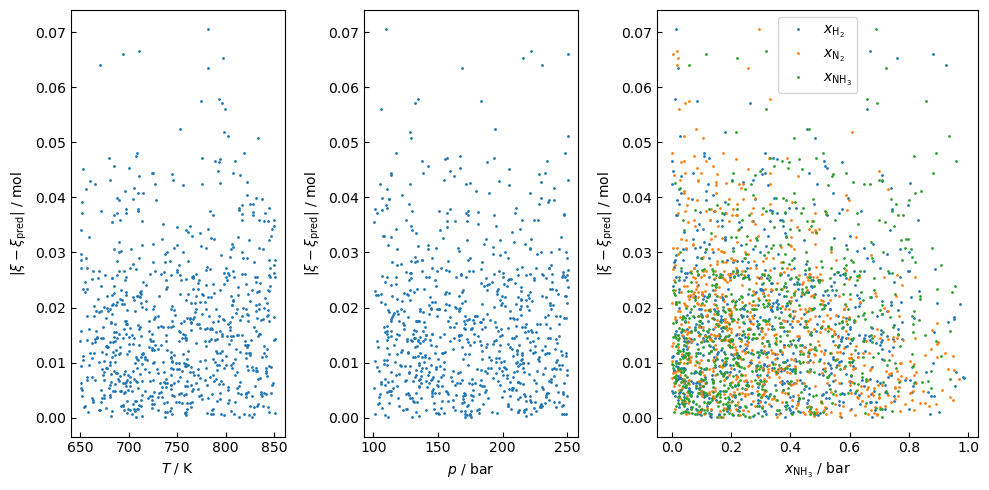

In [14]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

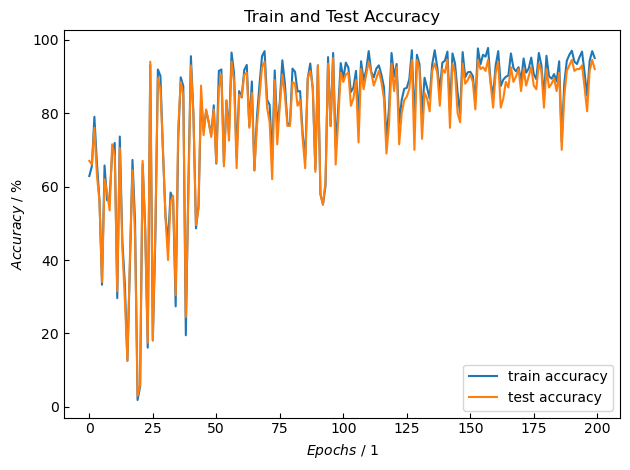

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[6.8600e+02, 1.2603e+02, 2.5453e-01, 1.0076e-01, 6.4471e-01],
        [7.5218e+02, 1.3146e+02, 6.7328e-01, 1.9960e-01, 1.2712e-01],
        [6.8824e+02, 1.3350e+02, 2.3740e-01, 3.0713e-01, 4.5547e-01],
        [7.9858e+02, 1.2925e+02, 5.1166e-02, 3.6352e-01, 5.8531e-01],
        [8.3996e+02, 1.5045e+02, 6.1881e-01, 2.2570e-01, 1.5548e-01],
        [7.7466e+02, 1.7554e+02, 2.0764e-01, 3.0624e-01, 4.8612e-01],
        [8.2702e+02, 1.6906e+02, 1.3947e-01, 3.3752e-01, 5.2301e-01],
        [8.2088e+02, 1.5333e+02, 6.2761e-01, 2.4678e-01, 1.2560e-01],
        [7.9817e+02, 1.7209e+02, 1.7247e-01, 2.1098e-01, 6.1655e-01],
        [8.2402e+02, 2.3611e+02, 8.6522e-02, 2.1716e-01, 6.9632e-01],
        [7.6970e+02, 1.5083e+02, 5.3403e-01, 1.8994e-01, 2.7603e-01],
        [7.1241e+02, 2.1009e+02, 7.2499e-01, 1.1089e-01, 1.6411e-01],
        [7.6301e+02, 1.6681e+02, 8.5967e-01, 1.0198e-01, 3.8349e-02],
        [7.1340e+02, 1.4198e+02, 5.8910e-01, 7.0767e-02, 3.4013e-01],
        [7.5919e+02,

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.8882, 0.8658, 0.9111, 0.8716, 0.9157], requires_grad=True),
 Parameter containing:
 tensor([ 0.0988, -0.1399, -0.1307,  0.4094, -0.0907], requires_grad=True),
 Parameter containing:
 tensor([[ 2.7710e-01, -2.9471e-01,  1.7779e-01, -9.0364e-02,  5.4365e-01],
         [ 2.8225e-01, -3.2015e-01,  1.6453e-01, -2.0701e-01,  1.4254e-01],
         [ 3.6180e-01,  4.6572e-01, -4.4196e-02, -2.4099e-01, -5.3806e-02],
         [-1.9692e-01,  3.1349e-01, -2.8421e-01,  3.5087e-01, -3.5414e-01],
         [ 2.3961e-01,  6.6594e-02, -4.0112e-01,  3.6809e-03, -3.5541e-02],
         [ 1.8587e-02,  3.0832e-01,  1.3460e-01,  2.8825e-01,  2.2030e-01],
         [ 3.2556e-02,  1.3555e-01,  2.3875e-01,  2.9837e-01,  5.4419e-01],
         [-1.8806e-02,  1.4558e-01, -3.4970e-02, -3.4105e-01, -1.1759e-01],
         [ 2.4129e-01,  1.2286e-01, -2.5912e-02,  8.7144e-02, -8.1173e-02],
         [-2.4610e-01, -2.1428e-01, -1.1204e-02, -3.6923e-01, -1.1632e-01],
         [ 2.1639e-01, -

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1903, 0.5789, 0.5635, 0.9382, 0.6642],
        [0.6055, 0.4847, 0.2146, 0.3187, 0.1452]])
tensor([[-0.0251],
        [-0.1569]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[8.3996e+02, 1.5045e+02, 6.1881e-01, 2.2570e-01, 1.5548e-01],
        [8.1671e+02, 2.4731e+02, 1.7561e-01, 3.0300e-01, 5.2139e-01],
        [7.6961e+02, 2.3780e+02, 3.7007e-01, 4.6731e-01, 1.6262e-01],
        [7.9858e+02, 1.2925e+02, 5.1166e-02, 3.6352e-01, 5.8531e-01],
        [6.9023e+02, 2.3948e+02, 1.1377e-01, 8.5668e-02, 8.0056e-01],
        [7.7372e+02, 2.0126e+02, 1.2444e-02, 8.0541e-01, 1.8215e-01],
        [7.3878e+02, 1.0867e+02, 1.4930e-02, 9.7047e-01, 1.4596e-02],
        [8.2839e+02, 2.4726e+02, 5.2262e-01, 2.1650e-01, 2.6088e-01],
        [6.8059e+02, 1.9958e+02, 2.1350e-01, 6.2533e-01, 1.6117e-01],
        [7.1703e+02, 1.4992e+02, 5.0058e-01, 3.4857e-01, 1.5084e-01],
        [6.9060e+02, 1.3655e+02, 2.1355e-02, 7.7339e-01, 2.0526e-01],
        [8.3428e+02, 1.4943e+02, 5.3225e-01, 1.9618e-01, 2.7156e-01],
        [6.6006e+02, 1.3633e+02, 3.1752e-01, 6.6606e-01, 1.6417e-02],
        [7.5228e+02, 2.1961e+02, 2.1126e-02, 2.2487e-01, 7.5400e-01],
        [6.6752e+02,

#### Histogramme Verteilung von $xi$ und $x{_i}$

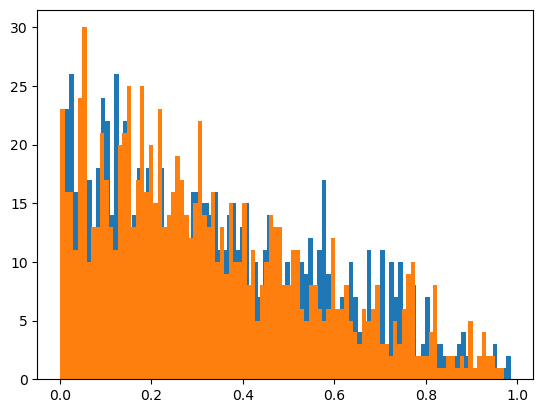

In [21]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

In [22]:
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

Test MRE,▆▅█▅▃▂▁▂▂▁▂▂▁▂▂▁▁▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test loss,▇▆▆█▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train MRE,▆█▆▅▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train loss,▇▇▆█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test MRE,1.92509
Test loss,0.00679
Train MRE,0.47444
Train loss,0.00618
